In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression

from PIL import Image
import warnings

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing 
warnings.filterwarnings("ignore", message="UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images")

In [2]:
# setup cell
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 200
print('using device:', device)

using device: cpu


In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

repo_path = Path('git/tree-finder/')
full_repo_path = Path('/content/drive/My Drive ') / repo_path
model_path = full_repo_path / 'models'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(repo_path))

Mounted at /content/drive


In [4]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings
from notebooks.train_fns import flatten, Flatten, check_accuracy, train_model

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

In [5]:
set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [6]:
# make dataset
SCALE = 1024
CROP = SCALE
SCALE_TEMP = 224 # for training

# define transformations
# normalization per pytorch documentation for pretrained models
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
tnorm = T.Normalize(mean, std)
transforms = {}
transforms['orig'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor(), tnorm])
transforms['mirr'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), T.RandomHorizontalFlip(1), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor(), tnorm])

# include a random cropping (flipped and unflipped) at three crop sizes
for pct in [10, 25, 50]:
    scale_param = int(1 / (pct*0.01))
    transforms[f'crop{pct}'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                          T.Resize(SCALE_TEMP),
                                          T.ToTensor(), tnorm])
    transforms[f'crop{pct}_mirr'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                               T.RandomHorizontalFlip(1),
                                               T.Resize(SCALE_TEMP),
                                               T.ToTensor(), tnorm])

In [7]:
# create dataset by concatenating all transformations
binds = []
for t in transforms:
    df = dset.ImageFolder(root= full_repo_path / 'data/images_bin', transform=transforms[t])
    binds.append(df)

binds = ConcatDataset(binds)
classes = binds.datasets[0].classes

In [8]:
# make dataloaders
PCT_TRAIN, PCT_VAL = 0.75, 0.15
N = len(binds)
ds_lens = {}
ds_lens['all'] = N
ds_lens['train'] = int(N * PCT_TRAIN)
ds_lens['validate'] = int(N * PCT_VAL)
ds_lens['test'] = N - ds_lens['train'] - ds_lens['validate']
print(ds_lens)


# make loaders
dataloaders = {}
dataloaders['all'] = DataLoader(dataset=binds, batch_size=N, shuffle=False)
dataloaders['train'] = DataLoader(binds, batch_size=32,
                           sampler=sampler.SubsetRandomSampler(range(ds_lens['train'])))
dataloaders['validate'] = DataLoader(binds, batch_size=32,
                           sampler=sampler.SubsetRandomSampler(range(ds_lens['train'], ds_lens['train']+ds_lens['validate'])))
dataloaders['test'] = DataLoader(binds, batch_size=32,
                           sampler=sampler.SubsetRandomSampler(range(ds_lens['train']+ds_lens['validate'], N)))

{'all': 3136, 'train': 2352, 'validate': 470, 'test': 314}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


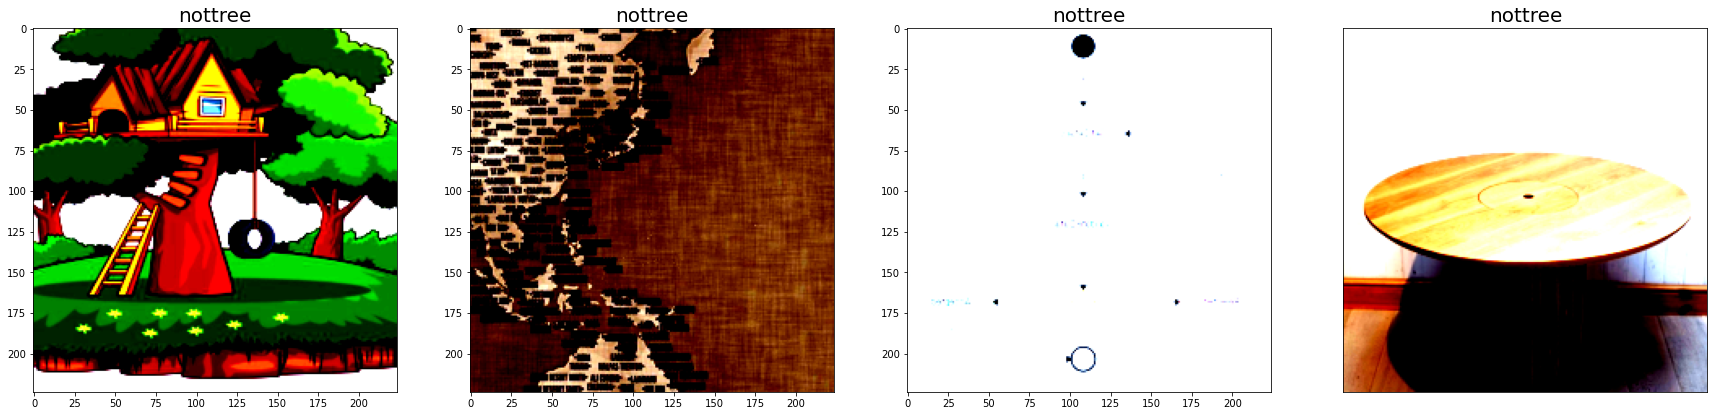

In [9]:
# visualize images
loader_samp = DataLoader(dataset=binds, batch_size=4, shuffle=True)

trainiter = iter(loader_samp)
imgs, labels = trainiter.next()

# print(type(imgs), type(labels))
show_image_batch(imgs, title=[classes[x] for x in labels])

# Retrain a pretrained model for binary classification of trees

In [10]:
model = models.resnet18(pretrained=True).to(device) # https://pytorch.org/vision/stable/models.html

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
for param in model.parameters():
    param.requires_grad = False  

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9) 
# optimizer = optim.Adam(model.fc.parameters())

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [12]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validate']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / ds_lens[phase]
            epoch_acc = running_corrects.double() / ds_lens[phase]

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [13]:
train_model(model, criterion, optimizer, 3)
torch.save(model.state_dict(), model_path / 'resnet.pt')

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train loss: 0.7730, acc: 0.3304
validate loss: 0.7920, acc: 0.2638
Epoch 2/3
----------
train loss: 0.7731, acc: 0.3112
validate loss: 0.7892, acc: 0.2809
Epoch 3/3
----------
train loss: 0.7723, acc: 0.3095
validate loss: 0.7915, acc: 0.2660


In [19]:
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'rerun pretrained model'
!git push

/content/drive/My Drive /git/tree-finder
[main b244338] rerun pretrained model
 2 files changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/train_binary_tree_classifier.ipynb (92%)
Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 40.25 MiB | 11.22 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/etrieschman/tree-finder
   9508fcd..b244338  main -> main
